<a href="https://colab.research.google.com/github/alyson-mei/ml_math_hw_1/blob/main/ml_math_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Библиотеки



In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Выдаёт ошибку как в этом ноутбуке, так и в семинарских. Но все библиотеки стандартные.
#if IN_COLAB:
#    !wget -q -O requirements.txt https://raw.githubusercontent.com/alyson-mei/ml_math_hw_1/main/requirements.txt
#    !pip install -q -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

from scipy.spatial.distance import cdist

## Задание и датасет

In [3]:
assert IN_COLAB, 'Use Colab!'
!wget https://raw.githubusercontent.com/alyson-mei/ml_math_hw/main/servo.csv
!wget https://raw.githubusercontent.com/alyson-mei/ml_math_hw/main/servo_info.txt
!wget https://raw.githubusercontent.com/alyson-mei/ml_math_hw_1/main/task.txt

--2023-10-15 18:55:53--  https://raw.githubusercontent.com/alyson-mei/ml_math_hw/main/servo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3186 (3.1K) [text/plain]
Saving to: ‘servo.csv’

servo.csv           100%[===================>]   3.11K  --.-KB/s    in 0s      

2023-10-15 18:55:53 (47.0 MB/s) - ‘servo.csv’ saved [3186/3186]

--2023-10-15 18:55:53--  https://raw.githubusercontent.com/alyson-mei/ml_math_hw/main/servo_info.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2136 (2.1K) [text/plain]
Saving to: ‘servo_info.

In [4]:
# описание задания
with open('/content/task.txt') as task:
    print(task.read())

Enter your mail: khranilov.an@phystech.edu
{'mail': 'khranilov.an@phystech.edu',
 'id': 3004501260,
 'type': 'regression',
 'dataset': {'name': 'Servo Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'},
 'method': ['Перцептрон', 'Линейная регрессия', 'Надарая-Ватсона']}



In [5]:
dataset = pd.read_csv('servo.csv', names = ('motor', 'screw', 'pgain', 'vgain', 'class'))
dataset.sample(5, random_state=0)

,motor,screw,pgain,vgain,class
150,B,A,5,4,0.806255
56,A,A,4,2,0.881255
123,C,E,3,1,1.299997
60,E,B,4,2,0.581253
100,B,C,4,2,0.506252


In [6]:
# информация о датасете
with open('/content/servo_info.txt') as info:
    print(info.read())


1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by

Сложно получить существенную информацию из визуального представления данных в задаче регрессии с (фактически) категориальными фичами. Ниже приведены гистограммы значения таргета для каждого из значений каждой из фичей. Из них видно только то, что общая зависимость достаточно сложная, что также написано в описании датасета.

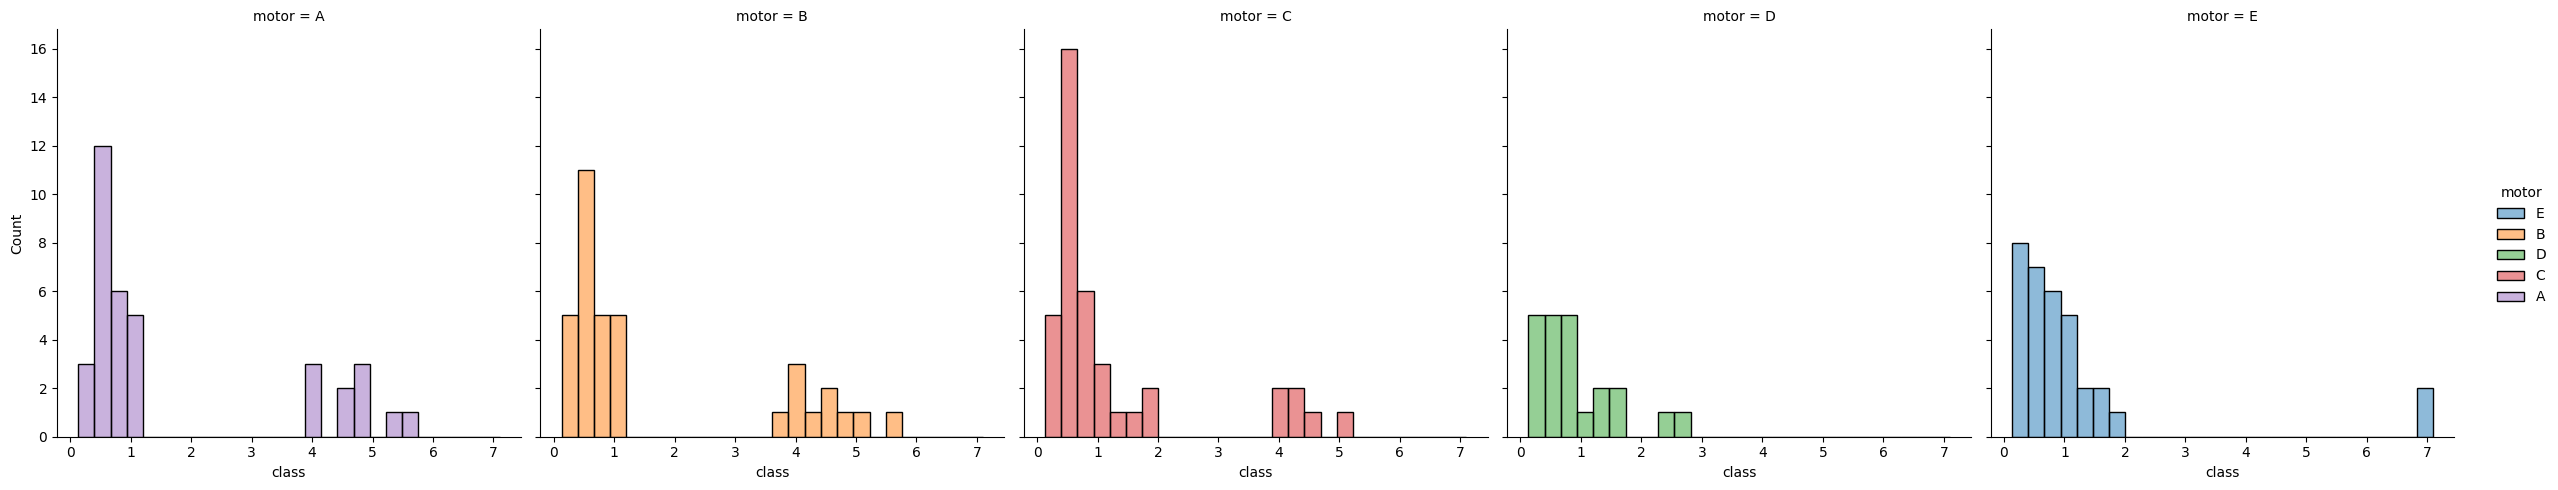

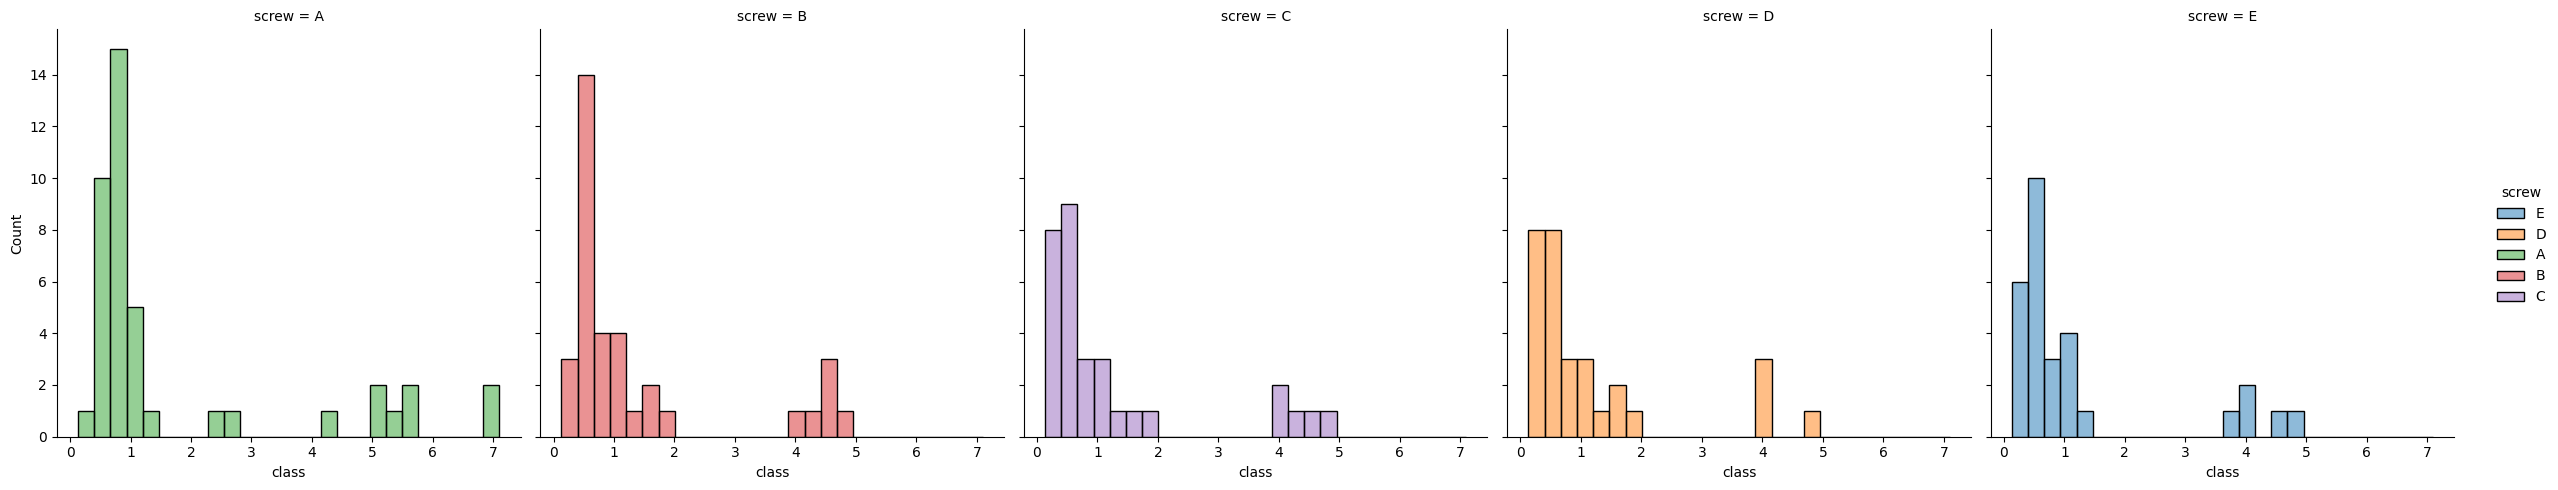

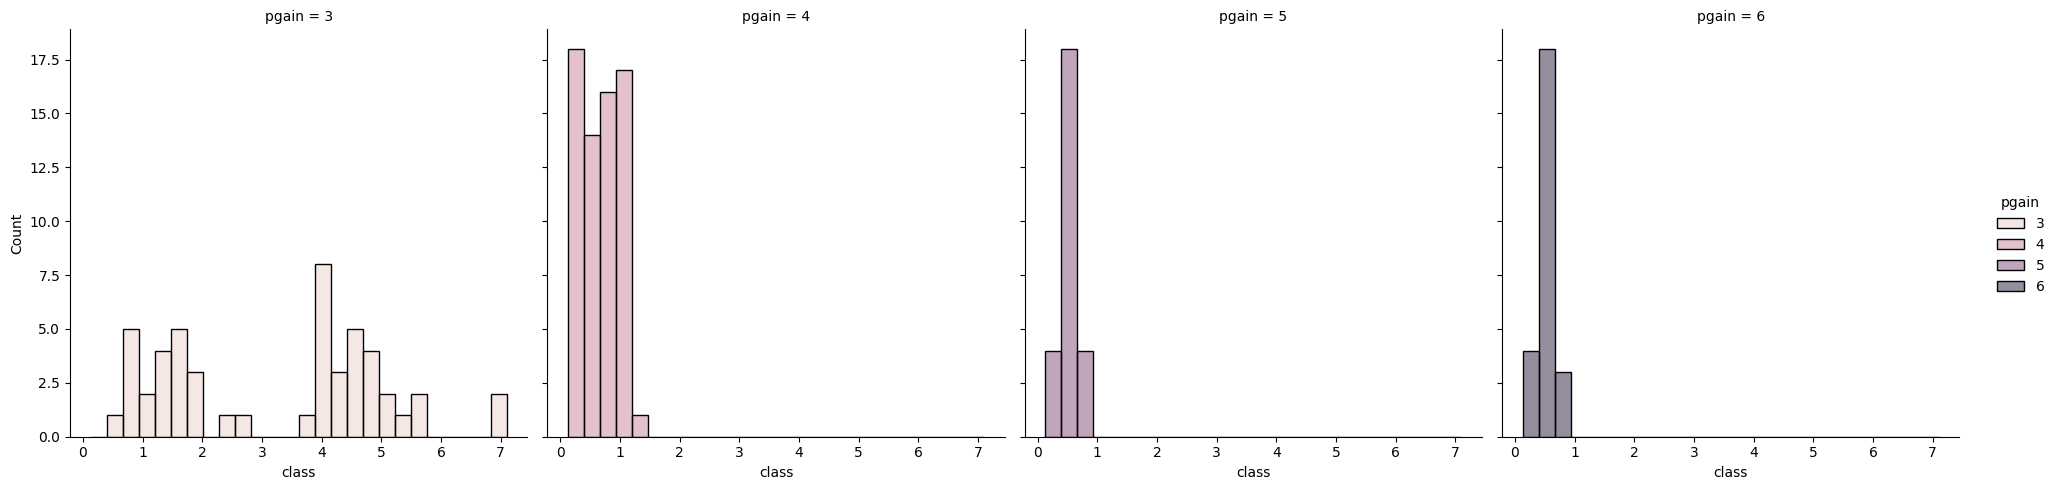

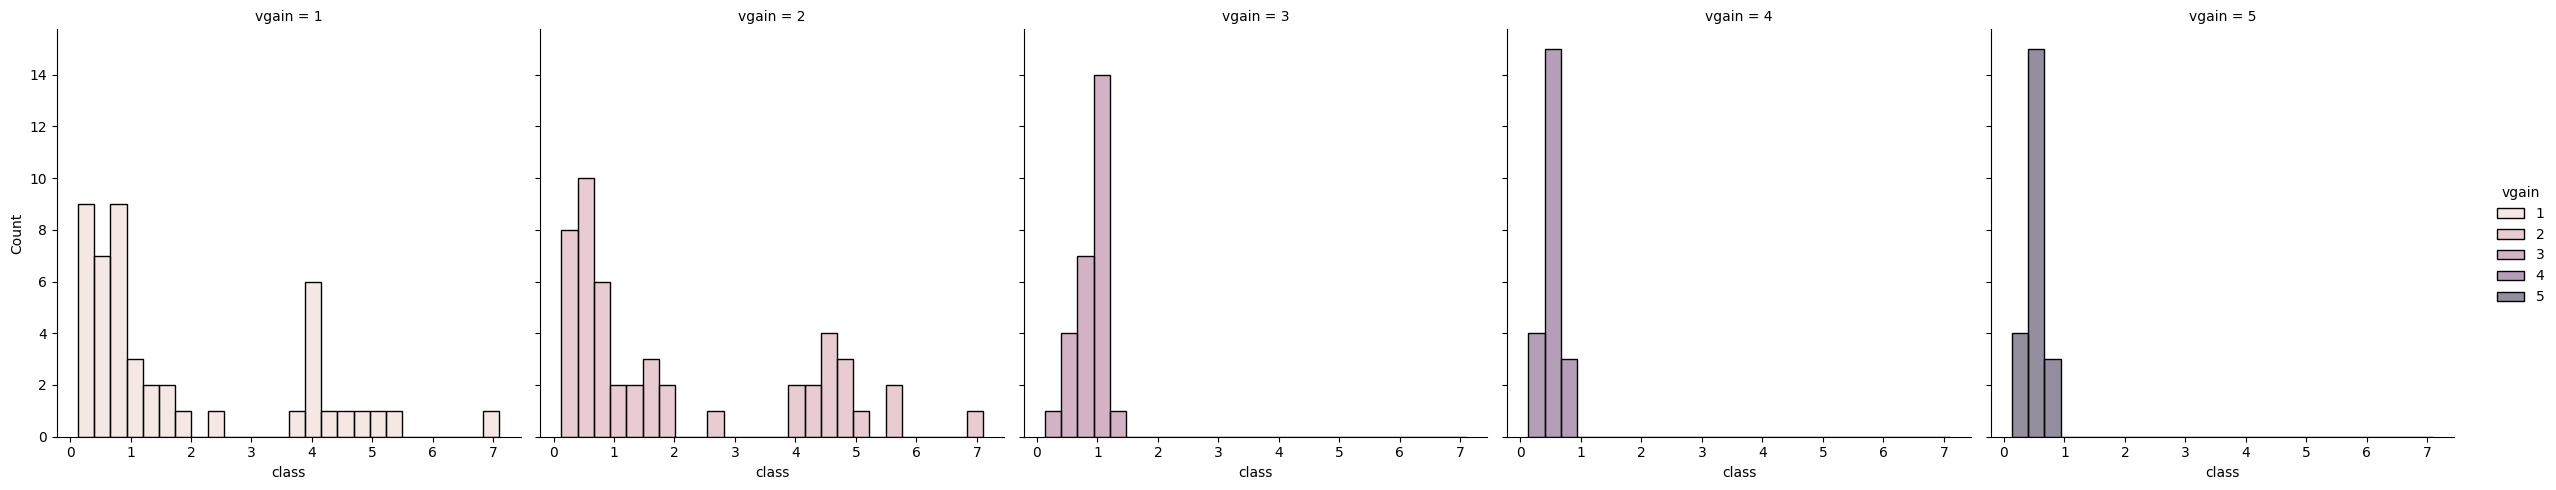

In [7]:
sns.displot(dataset, x="class", hue="motor", col="motor", col_order = ('A', 'B', 'C', 'D', 'E'))
sns.displot(dataset, x="class", hue="screw", col="screw", col_order = ('A', 'B', 'C', 'D', 'E'))
sns.displot(dataset, x="class", hue="pgain", col="pgain")
sns.displot(dataset, x="class", hue="vgain", col="vgain")

Задача регрессии: по четырём фичам, две из которых категориальные (motor, screw) и две не очень понятно какие (pgain, vgain) предсказываем непрерывную величину class. В описании датасета написано, что pgain и vgain "непрерывные", но они принимают 4 и 5 значений соответственно. Это много меньше числа объектов, поэтому разумно считать их категориальными. Для линейной регрессии попробуем оба варианта и, сравнив результаты, увидем, что всё действительно так.

## Предобработка данных

In [8]:
# преобразуем фичи с помощью dummy encoding, переводим фичи и таргет в numpy массивы X и y
# использования dummy encoding позволяет избавиться от мультиколлинеарности
# 1) считаем pgain и vgain категориальными
X = pd.get_dummies(dataset.iloc[:, :-1], columns = ['motor', 'screw', 'pgain', 'vgain'], drop_first = True).to_numpy()
y = dataset.iloc[:, -1].to_numpy()
X[:5], y[:5]


(array([[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=uint8),
 array([0.28125095, 0.5062525 , 0.35625148, 5.500033  , 0.35625148]))

In [9]:
# 2) считаем pgain и vgain числовыми
dataset_noncat = pd.get_dummies(dataset.iloc[:, :2], columns = ['motor', 'screw'], drop_first = True)
dataset_noncat[['pgain', 'vgain']] = dataset[['pgain', 'vgain']]
X_noncat = dataset_noncat.to_numpy()
X_noncat[:5], y[:5]

(array([[0, 0, 0, 1, 0, 0, 0, 1, 5, 4],
        [1, 0, 0, 0, 0, 0, 1, 0, 6, 5],
        [0, 0, 1, 0, 0, 0, 1, 0, 4, 3],
        [1, 0, 0, 0, 0, 0, 0, 0, 3, 2],
        [0, 0, 1, 0, 1, 0, 0, 0, 6, 5]]),
 array([0.28125095, 0.5062525 , 0.35625148, 5.500033  , 0.35625148]))

## Функции кросс-валидации и подбора параметров

Объектов мало, так что оцениваем качество с кросс-валидацией. Используем LOOCV и n-CV (кросс-валидацию с n фолдами). В качестве лосс-функций возьмём MAE и MSE. Их усреднение по фолдам кросс-валидации будем обозначать CVMAE и CVMSE соотвественно. Для случая LOOCV построим гиотограммы ошибок.

In [10]:
def number_split(length, number):
    '''
    Возвращает массив number+1 индексов для последующего разбиения массива длиной length на number частей
    '''
    indices = np.zeros(number+1)
    current_index = 0
    for i in range(number):
        quotient = length//(number - i)
        current_index += quotient
        indices[i+1] = current_index
        length -= quotient
    return indices.astype(int)

def CV(X, y, model, num_of_folds = 167, print_results = True):
    '''
    Детерминированная кросс-валидация с num_of_folds числом фолдов.
    arguments:
              X: датасет
              y: таргет
              model: модель
              num_of_folds: число фолдов разбиения датасета
    returns:
              mae: массив, на i-м месте в котором содержится MAE для i-го фолда
              mse: массив, на i-м месте в котором содержится MSE для i-го фолда
    '''
    mae = np.zeros(num_of_folds)
    mse = np.zeros(num_of_folds)
    indices = number_split(len(X), num_of_folds)
    for i in range(num_of_folds):
      X_train, X_test = np.concatenate((X[:indices[i]], X[indices[i+1]:])), X[indices[i]:indices[i+1]]
      y_train, y_test = np.concatenate((y[:indices[i]], y[indices[i+1]:])), y[indices[i]:indices[i+1]]
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mae[i] = mean_absolute_error(y_pred, y_test)
      mse[i] = mean_squared_error(y_pred, y_test)
    if print_results:
      print(f'CVMAE: {mae.mean()}')
      print(f'CVMSE: {mse.mean()}')
    return mae, mse

In [11]:
def MyGridSearchCV(model, parameters, num_of_folds = 5):
    '''
    Проводит подбор параметров на основе функции CV.
    returns:
            cases: список словарей с параметрами, CVMAE и CVMSE
    '''
    keys = parameters.keys()
    combinations = itertools.product(*parameters.values())
    cases = [dict(zip(keys, cc)) for cc in combinations]
    for param_case in cases:
      current_model = model.set_params(**param_case)
      mae, mse = CV(X, y, current_model, num_of_folds, print_results = False)
      param_case['CVMAE'] = mae.mean()
      param_case['CVMSE'] = mse.mean()
    return cases

def GridSearchCV_table(cases, sort_by = None):
    '''
    Строит датафрейм по списку словарей.
    returns:
            df: датафрейм
    '''
    df = pd.DataFrame.from_dict(cases)
    df = df.sort_values(sort_by)
    return df

In [12]:
def histogram_mae(mae, number_of_bins = 30):
    '''
    Строит гистограмму. Используем для построения гистограммы ошибок LOOCV.
    '''
    plt.hist(mae, bins = number_of_bins)
    plt.xlabel('Абсолютная ошибка')
    plt.ylabel('Число объектов в интервале')
    plt.show()

## Линейная регрессия

In [13]:
mean_y = np.mean(y)
print(f'Среднее для y: {np.mean(y)}')
print(f'Стадартное отклонение для y: {np.std(y)}')

Среднее для y: 1.3897083879041916
Стадартное отклонение для y: 1.5549585912047752


#### pgain и vgain категориальные

In [14]:
# LOOCV
mae = CV(X, y, LinearRegression())[0]

CVMAE: 0.6260861271835535
CVMSE: 0.6990491193043934


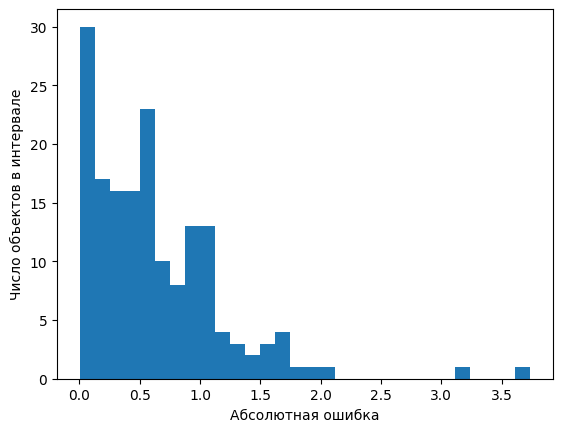

In [15]:
# гистограмма ошибок для LOOCV
histogram_mae(mae)

In [16]:
# CV с 11 фолдами
CV(X, y, LinearRegression(), 11);

CVMAE: 0.62732858680441
CVMSE: 0.7084765736419772


#### vgain и pgain числовые

In [17]:
# LOOCV
mae_noncat = CV(X_noncat, y, LinearRegression())[0]

CVMAE: 0.9057914917518263
CVMSE: 1.227540987329755


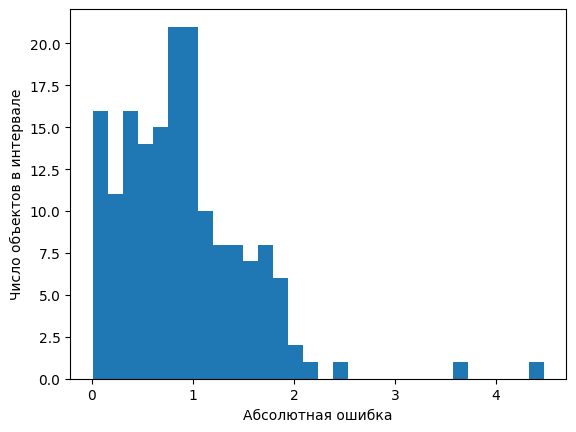

In [18]:
# гистограмма ошибок для LOOCV
histogram_mae(mae_noncat)

In [19]:
# CV с 11 фолдами
CV(X_noncat, y, LinearRegression(), 11);

CVMAE: 0.9056880262538679
CVMSE: 1.2344115709988566


Видим, что разумно считать все фичи категориальными. Также
заметим, что гистограмма показывает наличие нескольких значительных выбросов с большой ошибкой. Запомним их индексы и далее сравним с другими методами.

In [20]:
list_mae = pd.Series(mae)
i = list_mae.nlargest(5)
indices_linear = i.index.values.tolist()
indices_linear

[80, 58, 151, 35, 96]

## Перцептрон

Для простоты используем имплементацию в sklearn. В ней есть не все гиперпараметры (в частности, нет dropout). Будем подбирать размеры и число скрытых уровней, функцию активации. Для LOOCV (работает долго!) построим гистограмму ошибок.



#### CV

In [21]:
model = MLPRegressor(hidden_layer_sizes=(100,2), activation='relu', max_iter=300, random_state = 0)

In [22]:
# LOOCV, начальные гиперпараметры
mae = CV(X, y, model, 167)[0]

CVMAE: 0.5387843755573569
CVMSE: 0.7967256093035903


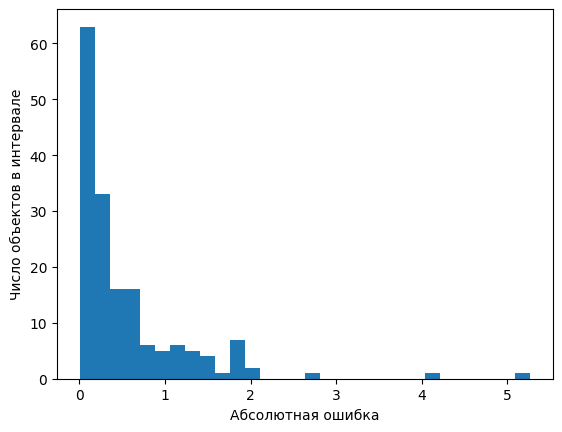

In [23]:
# гистограмма ошибок для LOOCV с начальными гиперпараметрами
histogram_mae(mae, number_of_bins = 30)

In [24]:
# CV с 5 фолдами
mae, mse = CV(X, y, model, 5)

CVMAE: 0.5498159666944293
CVMSE: 0.7602052326254111


#### Подбор гиперпараметров

In [25]:
parameters = { 'hidden_layer_sizes': [(a, b) for a in [100, 250, 300] for b in [9, 11, 13]],
              'activation': ['relu', 'logistic', 'tanh'] }

In [26]:
cases = MyGridSearchCV(model, parameters, num_of_folds = 5)

In [27]:
cases_df = GridSearchCV_table(cases, sort_by = 'CVMAE')
cases_df.head()

,hidden_layer_sizes,activation,CVMAE,CVMSE
14,"(250, 11)",tanh,0.288373,0.268555
26,"(300, 13)",tanh,0.301576,0.271341
20,"(300, 9)",tanh,0.302279,0.284921
9,"(250, 9)",relu,0.315122,0.293126
24,"(300, 13)",relu,0.319172,0.287318


Лучшие гиперпараметры из рассмотренных: 11 скрытых уровней размерности 250, функция активации tanh.

In [28]:
# LOOCV с подобранными гиперпараметрами
model = MLPRegressor(hidden_layer_sizes=(250,11), activation='tanh', max_iter=300, random_state = 0)
mae, mse = CV(X, y, model)

CVMAE: 0.27703183066077053
CVMSE: 0.23892047490236393


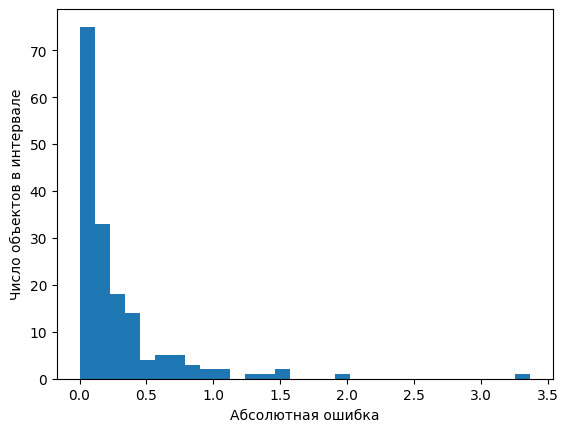

In [29]:
# гистограмма ошибок для LOOCV с подобранными гиперпараметрами
histogram_mae(mae, number_of_bins = 30)

Видим, что, как и в случае с линейной регрессией, есть несколько значительных выбросов.



In [30]:
list_mae = pd.Series(mae)
i = list_mae.nlargest(5)
indices_perceptron = i.index.values.tolist()
indices_perceptron

[80, 58, 48, 129, 123]

## Формула Надарая-Ватсона

Формула:
$$
a_h(x, X^l) = \frac{\sum_{i=1}^l y_i K \left(\frac{\rho(x,x^i)}{h}\right)}{\sum_{i=1}^l K \left(\frac{\rho(x,x^i)}{h}\right)}
$$
В этот раз возьмём код из семинарского ноутбука и модифицируем его.

In [31]:
class FNV(object):
    def __init__(self, kernel, h):
        self.X, self.Y = None, None
        self.kernel = kernel
        self.h = h
    def predict(self, X):
        features = np.sum(self.Y*self.kernel(cdist(X, self.X), self.h), axis=-1)       # cdist ([a1,a2], [b1,b2]) = || d(a1,b1) d(a1,b2) ||
        return features/(np.sum(self.kernel(cdist(X, self.X), self.h), axis=-1)+1e-10) #                            || d(a2,b1) d(a2,b2) ||
    def fit(self, X, Y, epoch=10):
        self.X, self.Y = np.array(X), np.array(Y)
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self



Рассмотрим три ядра: квадратичное, треугольное и гауссовское.

In [32]:
def quadratic(distance, h = 0.2): # квадратичное ядро: 1-r**2, |r|<=1
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [33]:
def triangle(distance, h = 0.2): # треугольное ядро: 1-|r|, |r|<=1
    ret = np.array(distance)/h
    return (1 - np.abs(ret)) * (np.abs(ret) <= 1)

In [34]:
def gauss(distance, h = 0.2): # гауссовское ядро: exp(-2r^2), |r|<=1
    ret = np.array(distance)/h
    return np.exp(-2*ret**2)

In [35]:
# LOOCV с начальными гиперпараметрами
model = FNV(triangle, h = 1.5)
mae = CV(X, y, model)[0]

CVMAE: 0.7600125010556362
CVMSE: 1.1126191117896418


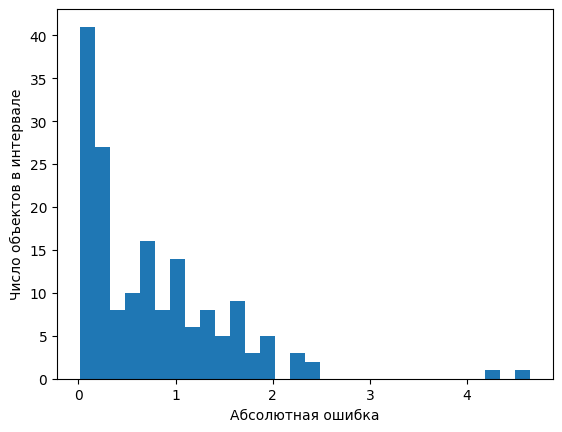

In [36]:
# гистограмма ошибок для LOOCV с начальными гиперпараметрами
histogram_mae(mae, number_of_bins = 30)

In [37]:
parameters = { 'h': [0.5 + 0.1*i for i in range(16)],
              'kernel': [quadratic, triangle, gauss] }
model = FNV(gauss, 0.2)


In [38]:
cases = MyGridSearchCV(model, parameters, num_of_folds = 5)


In [39]:
cases_df = GridSearchCV_table(cases, sort_by = 'CVMAE')
cases_df.head()

,h,kernel,CVMAE,CVMSE
8,0.7,<function gauss at 0x7a6514ca05e0>,0.698076,1.119310
5,0.6,<function gauss at 0x7a6514ca05e0>,0.700168,1.156600
11,0.8,<function gauss at 0x7a6514ca05e0>,0.700246,1.076740
2,0.5,<function gauss at 0x7a6514ca05e0>,0.701451,1.169525
19,1.1,<function triangle at 0x7a6514ca0310>,0.704496,1.172651


Лучшие гиперпараметры из рассмотренных: гауссовское ядро, h = 0.7.

In [40]:
# LOOCV с подобранными гиперпараметрами
model = FNV(gauss, h = 0.7)
mae = CV(X, y, model)[0]

CVMAE: 0.7317938146615309
CVMSE: 1.1259650833999277


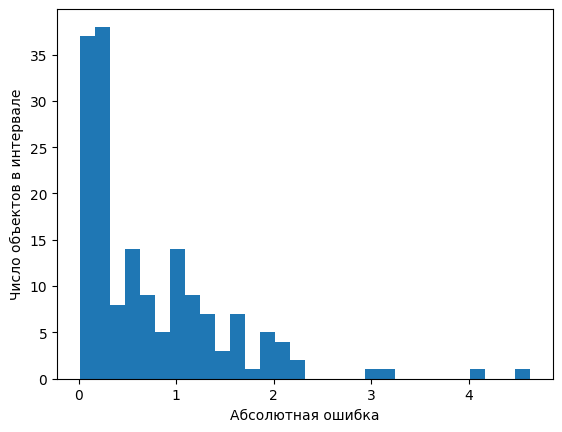

In [41]:
# гистограмма ошибок для LOOCV с подобранными гиперпараметрами
histogram_mae(mae, number_of_bins = 30)

Как и в прошлых методах, видны выбросы.

In [42]:
list_mae = pd.Series(mae)
i = list_mae.nlargest(5)
indices_nv = i.index.values.tolist()
indices_nv

[80, 58, 151, 96, 68]

## Объекты с максимальной ошибкой

In [43]:
print(f'Линейная регрессия: {indices_linear}')
print(f'Перцептрон: {indices_perceptron}')
print(f'Надарая-Ватсон: {indices_nv}')


Линейная регрессия: [80, 58, 151, 35, 96]
Перцептрон: [80, 58, 48, 129, 123]
Надарая-Ватсон: [80, 58, 151, 96, 68]


Самая большая ошибка в каждом из методов наблюдается на объектах 80 и 58. Также по два раза в списках выше встречаются объекты 151 и 96.

## Отчёт

Изученный датасет содержит достаточно сложную зависимость числовой переменной class от четырёх  признаков. Каждый из признаков оказалось разумно считать категориальным. Лучше всего с задачей регрессии справился перцептрон, линейная регрессия оказалась посередине, а метод Надарая-Ватсона дал худший результат. Для регрессии и перцептрона можно сравнить абсолютную ошибку с приведённой в описании датасета (разница в размере фолдов не имеет большого значения, как мы увидели выше). Для линейной регрессии результат оказался лучше (0.63 против 0.86), для перцептрона почти такой же, как в таблице для "нейронных сетей" (примерно 0.3). Возможно, что результат для регрессии помогло улучшить назначение vgain и pgain категориальными фичами (без этого результат 0.9).

При LOO кросс-валидации в каждом из случаев наблюдались объекты, на которых методы давали значительную ошибку, причём два из них совпали для каждого из  методов. Поскольку датасет получен из симуляции сервосистемы, сложно сделать предположение об их природе. Однако кажется, что можно просто считать их шумом и выбросить из датасета.


